In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel_Regularization'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel_Regularization(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 64),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(.1),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel_Regularization().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 3777


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.01),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=100,
    patience=100,
    delta=0,
    batch_size=512,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 81/81 [00:00<00:00, 385.54it/s]


Epoch   1/100: RMSE_train: 1,732,118, RMSE_val: 1,720,347


100%|██████████| 81/81 [00:00<00:00, 313.67it/s]


Epoch   2/100: RMSE_train: 1,680,402, RMSE_val: 1,606,901


100%|██████████| 81/81 [00:00<00:00, 431.45it/s]


Epoch   3/100: RMSE_train: 1,459,947, RMSE_val: 1,360,377


100%|██████████| 81/81 [00:00<00:00, 432.09it/s]


Epoch   4/100: RMSE_train: 1,167,317, RMSE_val: 1,325,076


100%|██████████| 81/81 [00:00<00:00, 435.07it/s]


Epoch   5/100: RMSE_train: 1,046,184, RMSE_val: 1,345,148
EarlyStopping counter: 1 out of 100


100%|██████████| 81/81 [00:00<00:00, 433.31it/s]


Epoch   6/100: RMSE_train: 996,979, RMSE_val: 1,333,929
EarlyStopping counter: 2 out of 100


100%|██████████| 81/81 [00:00<00:00, 325.67it/s]


Epoch   7/100: RMSE_train: 966,755, RMSE_val: 1,300,713


100%|██████████| 81/81 [00:00<00:00, 427.24it/s]


Epoch   8/100: RMSE_train: 948,358, RMSE_val: 1,249,153


100%|██████████| 81/81 [00:00<00:00, 429.16it/s]


Epoch   9/100: RMSE_train: 928,327, RMSE_val: 1,200,993


100%|██████████| 81/81 [00:00<00:00, 324.61it/s]


Epoch  10/100: RMSE_train: 917,578, RMSE_val: 1,156,793


100%|██████████| 81/81 [00:00<00:00, 384.38it/s]


Epoch  11/100: RMSE_train: 906,913, RMSE_val: 1,110,606


100%|██████████| 81/81 [00:00<00:00, 427.17it/s]


Epoch  12/100: RMSE_train: 891,333, RMSE_val: 1,072,647


100%|██████████| 81/81 [00:00<00:00, 432.53it/s]


Epoch  13/100: RMSE_train: 886,691, RMSE_val: 1,025,587


100%|██████████| 81/81 [00:00<00:00, 433.22it/s]


Epoch  14/100: RMSE_train: 878,412, RMSE_val: 1,002,637


100%|██████████| 81/81 [00:00<00:00, 319.06it/s]


Epoch  15/100: RMSE_train: 873,129, RMSE_val: 976,913


100%|██████████| 81/81 [00:00<00:00, 413.50it/s]


Epoch  16/100: RMSE_train: 868,235, RMSE_val: 950,466


100%|██████████| 81/81 [00:00<00:00, 430.76it/s]


Epoch  17/100: RMSE_train: 863,378, RMSE_val: 968,523
EarlyStopping counter: 1 out of 100


100%|██████████| 81/81 [00:00<00:00, 422.00it/s]


Epoch  18/100: RMSE_train: 860,816, RMSE_val: 927,765


100%|██████████| 81/81 [00:00<00:00, 425.32it/s]


Epoch  19/100: RMSE_train: 852,440, RMSE_val: 911,100


100%|██████████| 81/81 [00:00<00:00, 424.01it/s]


Epoch  20/100: RMSE_train: 849,108, RMSE_val: 900,098


100%|██████████| 81/81 [00:00<00:00, 417.03it/s]


Epoch  21/100: RMSE_train: 840,447, RMSE_val: 896,829


100%|██████████| 81/81 [00:00<00:00, 425.49it/s]


Epoch  22/100: RMSE_train: 842,200, RMSE_val: 900,970
EarlyStopping counter: 1 out of 100


100%|██████████| 81/81 [00:00<00:00, 432.75it/s]


Epoch  23/100: RMSE_train: 836,080, RMSE_val: 907,924
EarlyStopping counter: 2 out of 100


100%|██████████| 81/81 [00:00<00:00, 417.99it/s]


Epoch  24/100: RMSE_train: 836,493, RMSE_val: 900,804
EarlyStopping counter: 3 out of 100


100%|██████████| 81/81 [00:00<00:00, 432.14it/s]


Epoch  25/100: RMSE_train: 834,634, RMSE_val: 891,401


100%|██████████| 81/81 [00:00<00:00, 435.80it/s]


Epoch  26/100: RMSE_train: 831,191, RMSE_val: 900,521
EarlyStopping counter: 1 out of 100


100%|██████████| 81/81 [00:00<00:00, 320.21it/s]


Epoch  27/100: RMSE_train: 825,399, RMSE_val: 898,046
EarlyStopping counter: 2 out of 100


100%|██████████| 81/81 [00:00<00:00, 434.14it/s]


Epoch  28/100: RMSE_train: 823,169, RMSE_val: 901,095
EarlyStopping counter: 3 out of 100


100%|██████████| 81/81 [00:00<00:00, 432.35it/s]


Epoch  29/100: RMSE_train: 829,530, RMSE_val: 904,008
EarlyStopping counter: 4 out of 100


100%|██████████| 81/81 [00:00<00:00, 433.26it/s]


Epoch  30/100: RMSE_train: 822,772, RMSE_val: 903,392
EarlyStopping counter: 5 out of 100


100%|██████████| 81/81 [00:00<00:00, 385.05it/s]


Epoch  31/100: RMSE_train: 824,517, RMSE_val: 906,110
EarlyStopping counter: 6 out of 100


100%|██████████| 81/81 [00:00<00:00, 323.86it/s]


Epoch  32/100: RMSE_train: 822,529, RMSE_val: 900,793
EarlyStopping counter: 7 out of 100


100%|██████████| 81/81 [00:00<00:00, 413.74it/s]


Epoch  33/100: RMSE_train: 816,431, RMSE_val: 908,335
EarlyStopping counter: 8 out of 100


100%|██████████| 81/81 [00:00<00:00, 408.03it/s]


Epoch  34/100: RMSE_train: 818,792, RMSE_val: 915,208
EarlyStopping counter: 9 out of 100


100%|██████████| 81/81 [00:00<00:00, 305.79it/s]


Epoch  35/100: RMSE_train: 816,493, RMSE_val: 905,819
EarlyStopping counter: 10 out of 100


100%|██████████| 81/81 [00:00<00:00, 423.56it/s]


Epoch  36/100: RMSE_train: 813,757, RMSE_val: 906,085
EarlyStopping counter: 11 out of 100


100%|██████████| 81/81 [00:00<00:00, 373.82it/s]


Epoch  37/100: RMSE_train: 815,779, RMSE_val: 915,799
EarlyStopping counter: 12 out of 100


100%|██████████| 81/81 [00:00<00:00, 398.75it/s]


Epoch  38/100: RMSE_train: 809,421, RMSE_val: 904,945
EarlyStopping counter: 13 out of 100


100%|██████████| 81/81 [00:00<00:00, 425.99it/s]


Epoch  39/100: RMSE_train: 812,866, RMSE_val: 905,425
EarlyStopping counter: 14 out of 100


100%|██████████| 81/81 [00:00<00:00, 377.64it/s]


Epoch  40/100: RMSE_train: 814,996, RMSE_val: 911,291
EarlyStopping counter: 15 out of 100


100%|██████████| 81/81 [00:00<00:00, 398.68it/s]


Epoch  41/100: RMSE_train: 815,132, RMSE_val: 918,785
EarlyStopping counter: 16 out of 100


100%|██████████| 81/81 [00:00<00:00, 414.86it/s]


Epoch  42/100: RMSE_train: 811,081, RMSE_val: 907,048
EarlyStopping counter: 17 out of 100


100%|██████████| 81/81 [00:00<00:00, 306.20it/s]


Epoch  43/100: RMSE_train: 808,613, RMSE_val: 911,133
EarlyStopping counter: 18 out of 100


100%|██████████| 81/81 [00:00<00:00, 431.16it/s]


Epoch  44/100: RMSE_train: 808,363, RMSE_val: 911,641
EarlyStopping counter: 19 out of 100


100%|██████████| 81/81 [00:00<00:00, 395.87it/s]


Epoch  45/100: RMSE_train: 808,180, RMSE_val: 909,325
EarlyStopping counter: 20 out of 100


100%|██████████| 81/81 [00:00<00:00, 371.62it/s]


Epoch  46/100: RMSE_train: 804,451, RMSE_val: 914,060
EarlyStopping counter: 21 out of 100


100%|██████████| 81/81 [00:00<00:00, 412.79it/s]


Epoch  47/100: RMSE_train: 808,315, RMSE_val: 910,577
EarlyStopping counter: 22 out of 100


100%|██████████| 81/81 [00:00<00:00, 309.72it/s]


Epoch  48/100: RMSE_train: 808,587, RMSE_val: 915,825
EarlyStopping counter: 23 out of 100


100%|██████████| 81/81 [00:00<00:00, 400.17it/s]


Epoch  49/100: RMSE_train: 806,890, RMSE_val: 909,931
EarlyStopping counter: 24 out of 100


100%|██████████| 81/81 [00:00<00:00, 411.64it/s]


Epoch  50/100: RMSE_train: 807,161, RMSE_val: 920,105
EarlyStopping counter: 25 out of 100


100%|██████████| 81/81 [00:00<00:00, 305.44it/s]


Epoch  51/100: RMSE_train: 806,082, RMSE_val: 923,439
EarlyStopping counter: 26 out of 100


100%|██████████| 81/81 [00:00<00:00, 427.87it/s]


Epoch  52/100: RMSE_train: 806,818, RMSE_val: 913,500
EarlyStopping counter: 27 out of 100


100%|██████████| 81/81 [00:00<00:00, 392.72it/s]


Epoch  53/100: RMSE_train: 806,216, RMSE_val: 922,701
EarlyStopping counter: 28 out of 100


100%|██████████| 81/81 [00:00<00:00, 409.12it/s]


Epoch  54/100: RMSE_train: 816,229, RMSE_val: 913,453
EarlyStopping counter: 29 out of 100


100%|██████████| 81/81 [00:00<00:00, 410.03it/s]


Epoch  55/100: RMSE_train: 802,386, RMSE_val: 917,256
EarlyStopping counter: 30 out of 100


100%|██████████| 81/81 [00:00<00:00, 428.13it/s]


Epoch  56/100: RMSE_train: 807,544, RMSE_val: 915,338
EarlyStopping counter: 31 out of 100


100%|██████████| 81/81 [00:00<00:00, 409.25it/s]


Epoch  57/100: RMSE_train: 806,333, RMSE_val: 910,424
EarlyStopping counter: 32 out of 100


100%|██████████| 81/81 [00:00<00:00, 387.65it/s]


Epoch  58/100: RMSE_train: 810,124, RMSE_val: 914,299
EarlyStopping counter: 33 out of 100


100%|██████████| 81/81 [00:00<00:00, 307.76it/s]


Epoch  59/100: RMSE_train: 807,436, RMSE_val: 917,140
EarlyStopping counter: 34 out of 100


100%|██████████| 81/81 [00:00<00:00, 375.89it/s]


Epoch  60/100: RMSE_train: 804,204, RMSE_val: 919,549
EarlyStopping counter: 35 out of 100


100%|██████████| 81/81 [00:00<00:00, 431.44it/s]


Epoch  61/100: RMSE_train: 809,116, RMSE_val: 919,212
EarlyStopping counter: 36 out of 100


100%|██████████| 81/81 [00:00<00:00, 432.92it/s]


Epoch  62/100: RMSE_train: 807,364, RMSE_val: 916,273
EarlyStopping counter: 37 out of 100


100%|██████████| 81/81 [00:00<00:00, 414.99it/s]


Epoch  63/100: RMSE_train: 801,637, RMSE_val: 915,003
EarlyStopping counter: 38 out of 100


100%|██████████| 81/81 [00:00<00:00, 308.06it/s]


Epoch  64/100: RMSE_train: 807,137, RMSE_val: 916,691
EarlyStopping counter: 39 out of 100


100%|██████████| 81/81 [00:00<00:00, 421.49it/s]


Epoch  65/100: RMSE_train: 808,632, RMSE_val: 912,977
EarlyStopping counter: 40 out of 100


100%|██████████| 81/81 [00:00<00:00, 420.29it/s]


Epoch  66/100: RMSE_train: 808,646, RMSE_val: 914,734
EarlyStopping counter: 41 out of 100


100%|██████████| 81/81 [00:00<00:00, 324.59it/s]


Epoch  67/100: RMSE_train: 801,111, RMSE_val: 921,391
EarlyStopping counter: 42 out of 100


100%|██████████| 81/81 [00:00<00:00, 436.08it/s]


Epoch  68/100: RMSE_train: 801,329, RMSE_val: 923,429
EarlyStopping counter: 43 out of 100


100%|██████████| 81/81 [00:00<00:00, 418.09it/s]


Epoch  69/100: RMSE_train: 802,804, RMSE_val: 915,550
EarlyStopping counter: 44 out of 100


100%|██████████| 81/81 [00:00<00:00, 433.07it/s]


Epoch  70/100: RMSE_train: 808,974, RMSE_val: 911,715
EarlyStopping counter: 45 out of 100


100%|██████████| 81/81 [00:00<00:00, 432.50it/s]


Epoch  71/100: RMSE_train: 805,914, RMSE_val: 912,647
EarlyStopping counter: 46 out of 100


100%|██████████| 81/81 [00:00<00:00, 422.74it/s]


Epoch  72/100: RMSE_train: 804,437, RMSE_val: 907,827
EarlyStopping counter: 47 out of 100


100%|██████████| 81/81 [00:00<00:00, 429.62it/s]


Epoch  73/100: RMSE_train: 807,134, RMSE_val: 928,427
EarlyStopping counter: 48 out of 100


100%|██████████| 81/81 [00:00<00:00, 430.60it/s]


Epoch  74/100: RMSE_train: 807,170, RMSE_val: 908,075
EarlyStopping counter: 49 out of 100


100%|██████████| 81/81 [00:00<00:00, 320.89it/s]


Epoch  75/100: RMSE_train: 804,233, RMSE_val: 913,061
EarlyStopping counter: 50 out of 100


100%|██████████| 81/81 [00:00<00:00, 428.21it/s]


Epoch  76/100: RMSE_train: 799,813, RMSE_val: 909,883
EarlyStopping counter: 51 out of 100


100%|██████████| 81/81 [00:00<00:00, 432.65it/s]


Epoch  77/100: RMSE_train: 800,525, RMSE_val: 911,307
EarlyStopping counter: 52 out of 100


100%|██████████| 81/81 [00:00<00:00, 434.93it/s]


Epoch  78/100: RMSE_train: 799,924, RMSE_val: 916,307
EarlyStopping counter: 53 out of 100


100%|██████████| 81/81 [00:00<00:00, 431.86it/s]


Epoch  79/100: RMSE_train: 804,735, RMSE_val: 910,899
EarlyStopping counter: 54 out of 100


100%|██████████| 81/81 [00:00<00:00, 328.41it/s]


Epoch  80/100: RMSE_train: 806,773, RMSE_val: 913,012
EarlyStopping counter: 55 out of 100


100%|██████████| 81/81 [00:00<00:00, 396.90it/s]


Epoch  81/100: RMSE_train: 796,528, RMSE_val: 912,735
EarlyStopping counter: 56 out of 100


100%|██████████| 81/81 [00:00<00:00, 427.19it/s]


Epoch  82/100: RMSE_train: 802,457, RMSE_val: 906,890
EarlyStopping counter: 57 out of 100


100%|██████████| 81/81 [00:00<00:00, 324.63it/s]


Epoch  83/100: RMSE_train: 806,215, RMSE_val: 910,303
EarlyStopping counter: 58 out of 100


100%|██████████| 81/81 [00:00<00:00, 438.62it/s]


Epoch  84/100: RMSE_train: 804,863, RMSE_val: 908,901
EarlyStopping counter: 59 out of 100


100%|██████████| 81/81 [00:00<00:00, 432.23it/s]


Epoch  85/100: RMSE_train: 804,620, RMSE_val: 910,810
EarlyStopping counter: 60 out of 100


100%|██████████| 81/81 [00:00<00:00, 436.07it/s]


Epoch  86/100: RMSE_train: 801,570, RMSE_val: 918,159
EarlyStopping counter: 61 out of 100


100%|██████████| 81/81 [00:00<00:00, 435.25it/s]


Epoch  87/100: RMSE_train: 806,573, RMSE_val: 915,320
EarlyStopping counter: 62 out of 100


100%|██████████| 81/81 [00:00<00:00, 431.53it/s]


Epoch  88/100: RMSE_train: 803,186, RMSE_val: 901,736
EarlyStopping counter: 63 out of 100


100%|██████████| 81/81 [00:00<00:00, 427.55it/s]


Epoch  89/100: RMSE_train: 803,406, RMSE_val: 927,052
EarlyStopping counter: 64 out of 100


100%|██████████| 81/81 [00:00<00:00, 434.96it/s]


Epoch  90/100: RMSE_train: 797,654, RMSE_val: 905,999
EarlyStopping counter: 65 out of 100


100%|██████████| 81/81 [00:00<00:00, 328.32it/s]


Epoch  91/100: RMSE_train: 801,965, RMSE_val: 911,018
EarlyStopping counter: 66 out of 100


100%|██████████| 81/81 [00:00<00:00, 432.03it/s]


Epoch  92/100: RMSE_train: 801,229, RMSE_val: 909,873
EarlyStopping counter: 67 out of 100


100%|██████████| 81/81 [00:00<00:00, 432.73it/s]


Epoch  93/100: RMSE_train: 804,659, RMSE_val: 916,425
EarlyStopping counter: 68 out of 100


100%|██████████| 81/81 [00:00<00:00, 414.19it/s]


Epoch  94/100: RMSE_train: 806,489, RMSE_val: 908,244
EarlyStopping counter: 69 out of 100


100%|██████████| 81/81 [00:00<00:00, 414.05it/s]


Epoch  95/100: RMSE_train: 801,084, RMSE_val: 924,306
EarlyStopping counter: 70 out of 100


100%|██████████| 81/81 [00:00<00:00, 323.81it/s]


Epoch  96/100: RMSE_train: 798,803, RMSE_val: 917,532
EarlyStopping counter: 71 out of 100


100%|██████████| 81/81 [00:00<00:00, 403.15it/s]


Epoch  97/100: RMSE_train: 801,244, RMSE_val: 924,678
EarlyStopping counter: 72 out of 100


100%|██████████| 81/81 [00:00<00:00, 410.26it/s]


Epoch  98/100: RMSE_train: 801,184, RMSE_val: 915,337
EarlyStopping counter: 73 out of 100


100%|██████████| 81/81 [00:00<00:00, 314.50it/s]


Epoch  99/100: RMSE_train: 802,525, RMSE_val: 911,573
EarlyStopping counter: 74 out of 100


100%|██████████| 81/81 [00:00<00:00, 398.91it/s]

Epoch 100/100: RMSE_train: 802,601, RMSE_val: 920,210
EarlyStopping counter: 75 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   782145.440  456201.384  0.604  0.608
val     900323.724  513736.806  0.659  0.471
test    929468.337  521506.805  0.649  0.442
--------------------------------------------
total   825871.495  475015.205  0.618  0.561


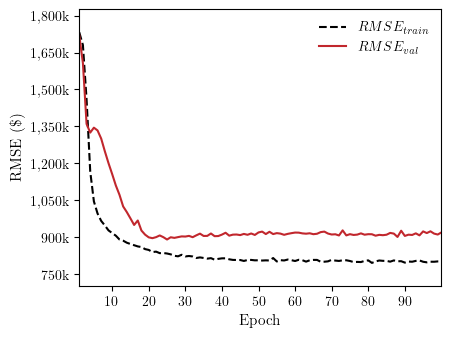

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

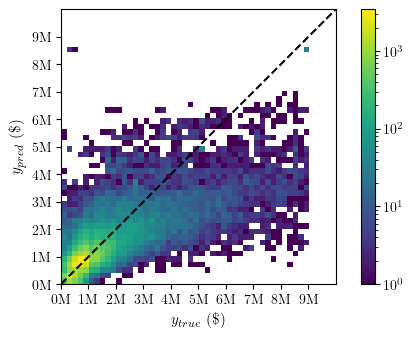

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')